In [1]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Dropout, Flatten

import tensorflow_addons as tfa
import cv2
import os 
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import accuracy_score
import random 
import time

AUTOTUNE = tf.data.AUTOTUNE


In [2]:
N_BEF_RES = 256
N_RES = 256 
# N_CLASSES = 143 
N_BATCH = 32 

In [3]:
PATH = 'C:/Users/user/Desktop/Child Skin Disease'
os.listdir('C:/Users/user/Desktop/Child Skin Disease')

['Total_Dataset', '소아피부질환 class.xlsx']

In [4]:
dataset = os.path.join(PATH, 'Total_Dataset')
dataset

'C:/Users/user/Desktop/Child Skin Disease\\Total_Dataset'

In [5]:
# Train & test set
limit_num = 0
base_num = 100
train_dict = {}
test_dict = {} 

for i in range(6):
    files = os.listdir(os.path.join(dataset, f'H{i}'))
    
    for f in files: 
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        if len(imgs) > limit_num: 
            train_dict[f] = len(imgs)
            
for i in range(7, 10): 
    files = [val for val in list(train_dict.keys())]
    
    for f in files:
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        test_dict[f] = len(imgs) 
        
train_dict, test_dict

({'Abscess': 61,
  'Acanthosis nigricans': 7,
  'Acne': 197,
  'Acne neonatorum': 18,
  'Acne scar integrated': 2,
  'Acquired tufted hamangioma': 23,
  'Alopecia areata': 221,
  'Anetoderma': 14,
  'Angioedema': 4,
  'Angiofibroma': 17,
  'Angiokeratoma': 1,
  'Angular cheilitis': 53,
  'Aplasia cutis, congenital': 18,
  "Beau's lines": 2,
  "Becker's nevus": 16,
  'Blue nevus': 5,
  'Cafe-au-lait spot': 292,
  'Cellulitis': 62,
  'Cheilitis': 39,
  'Chicken pox (varicella)': 47,
  'Childhood granulomatous periorificial dermatitis': 200,
  'Confluent and reticulated papillomatosis': 4,
  'Congenital Hemangioma': 22,
  'Contact dermatitis': 285,
  'Corn, Callus': 1,
  'Cutaneous larva migrans': 12,
  'Cutaneous lupus erythematosus': 80,
  'Cutis marmorata': 10,
  'Cutis marmorata telangiectatica congenita (CMTC)': 25,
  'Cyst integrated': 128,
  'Dermal Melanocytic Hamartoma': 2,
  'Dermatofibroma': 20,
  'Drug eruption': 372,
  'Dyshidrotic eczema': 5,
  'Eczema herpeticum': 20,
  'Ep

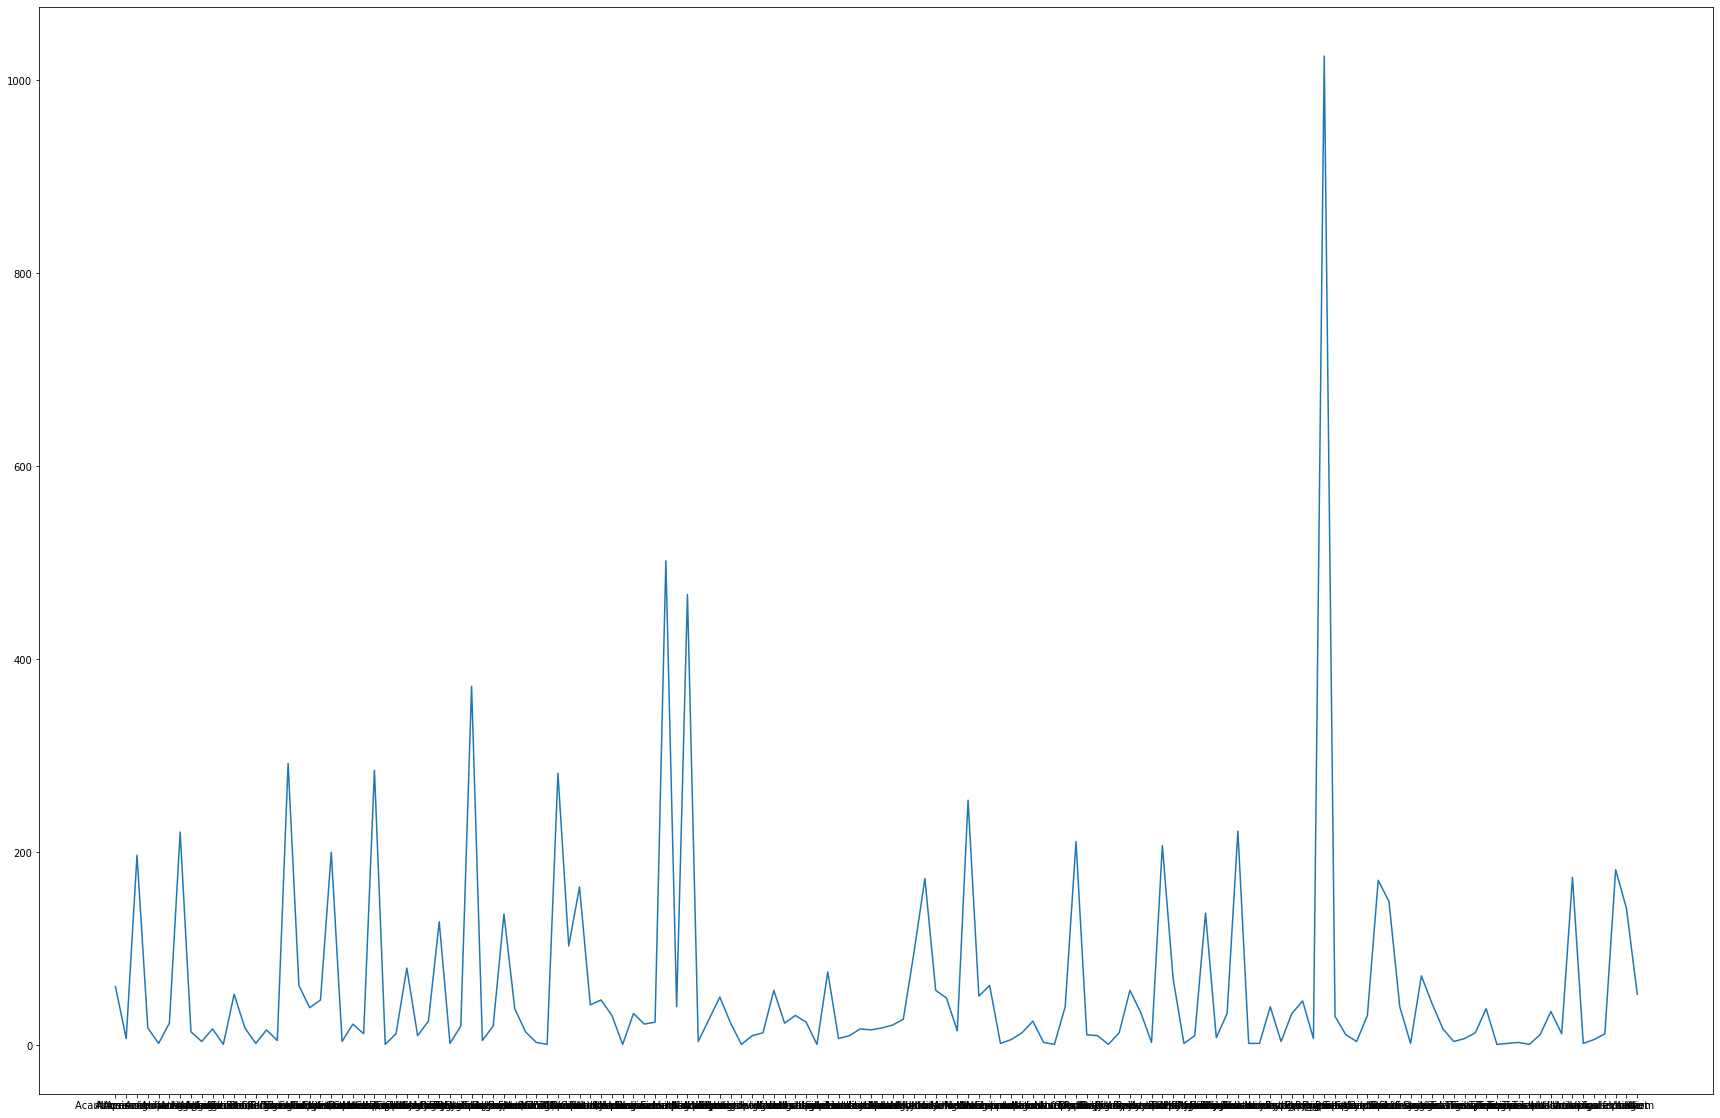

In [6]:
lists = sorted(train_dict.items())
lists

x, y = zip(*lists) 
plt.figure(figsize=(30, 20))
plt.plot(x, y)
plt.show()

In [7]:
N_CLASSES = len(train_dict)

In [8]:
train_images = [] 
test_images = []

for i in range(6):
    for key in train_dict.keys():
        img = glob(dataset + f'/H{str(i)}/{key}/*.jpg')
        train_images.extend(img) 
        
for i in range(7, 10):
    for key in train_dict.keys():
        img = glob(dataset + f'/H{str(i)}/{key}/*.jpg')
        test_images.extend(img) 
        
        
random.shuffle(train_images)
random.shuffle(test_images)
        
len(train_images), len(test_images)
        

(57558, 51092)

In [9]:
label_to_index = {}
for idx, key in zip(range(len(train_dict)), train_dict.keys()):
    label_to_index[key] = idx
    
label_to_index

{'Abscess': 0,
 'Acanthosis nigricans': 1,
 'Acne': 2,
 'Acne neonatorum': 3,
 'Acne scar integrated': 4,
 'Acquired tufted hamangioma': 5,
 'Alopecia areata': 6,
 'Anetoderma': 7,
 'Angioedema': 8,
 'Angiofibroma': 9,
 'Angiokeratoma': 10,
 'Angular cheilitis': 11,
 'Aplasia cutis, congenital': 12,
 "Beau's lines": 13,
 "Becker's nevus": 14,
 'Blue nevus': 15,
 'Cafe-au-lait spot': 16,
 'Cellulitis': 17,
 'Cheilitis': 18,
 'Chicken pox (varicella)': 19,
 'Childhood granulomatous periorificial dermatitis': 20,
 'Confluent and reticulated papillomatosis': 21,
 'Congenital Hemangioma': 22,
 'Contact dermatitis': 23,
 'Corn, Callus': 24,
 'Cutaneous larva migrans': 25,
 'Cutaneous lupus erythematosus': 26,
 'Cutis marmorata': 27,
 'Cutis marmorata telangiectatica congenita (CMTC)': 28,
 'Cyst integrated': 29,
 'Dermal Melanocytic Hamartoma': 30,
 'Dermatofibroma': 31,
 'Drug eruption': 32,
 'Dyshidrotic eczema': 33,
 'Eczema herpeticum': 34,
 'Epidermal nevus': 35,
 'Erythema dyschromicum

In [10]:
type(train_dict['Miliaria']),  type(base_num)

(int, int)

In [22]:
def train_skin_data(files):
    
    for file in files:
    
        f = file.decode('utf-8')
        
        img = cv2.imread(f, cv2.COLOR_BGR2YCR_CB)
        img = cv2.resize(img, (N_BEF_RES, N_BEF_RES))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

        idx = f.split('\\')[1].split('/')[2]
        lbl = tf.keras.utils.to_categorical(label_to_index[idx], len(train_dict))

        yield (img, lbl)    
        
        # if lower than base num, should apply data augmentation
        if base_num <= int(train_dict[idx]):

            # Btight 
            random_bright_tensor = tf.image.random_brightness(img, max_delta=128)
            random_bright_tensor = tf.clip_by_value(random_bright_tensor, 0, 255)
            random_bright_image = tf.keras.preprocessing.image.array_to_img(random_bright_tensor)
            yield (random_bright_tensor, lbl) 
    
            # rotation
            rotated_img = tf.image.rot90(img)        
            yield (rotated_img, lbl) 
            
            # curmix 
            cutmixed_img, cutmixed_lbl = cutmix(img, lbl)
            yield (cutmixed_img, cutmixed_lbl)

        

In [23]:
def test_skin_data(files):
    
    for file in files:
    
        f = file.decode('utf-8')
        
        img = cv2.imread(f, cv2.COLOR_BGR2YCR_CB)
        img = cv2.resize(img, (N_BEF_RES, N_BEF_RES))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        
        lbl = tf.keras.utils.to_categorical(label_to_index[f.split('\\')[1].split('/')[2]], len(train_dict))

        yield (img, lbl)    

In [24]:
def cutmix(images, labels):
    # imgs = []; labs = []
    # for i in range(N_BATCH):
    APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32)
    idx = tf.random.uniform((), 0, len(train_images), tf.int32)
    
    # random_img = 0 
    # random_lbl = 0 
    
    random_img = cv2.imread(train_images[idx], cv2.COLOR_BGR2YCR_CB)
    random_img = cv2.resize(random_img, (N_BEF_RES, N_BEF_RES))
    random_img = cv2.normalize(random_img, None, 0, 255, cv2.NORM_MINMAX)
    random_lbl = tf.keras.utils.to_categorical(label_to_index[train_images[idx].split('\\')[1].split('/')[2]], len(train_dict))

    W = N_RES
    H = N_RES
    lam = tf.random.uniform(())
    cut_ratio = tf.math.sqrt(1.-lam)
    cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
    cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY

    cx = tf.random.uniform((), int(W/8), int(7/8*W), tf.int32)
    cy = tf.random.uniform((), int(H/8), int(7/8*H), tf.int32)

    xmin = tf.clip_by_value(cx - cut_w//2, 0, W)
    ymin = tf.clip_by_value(cy - cut_h//2, 0, H)
    xmax = tf.clip_by_value(cx + cut_w//2, 0, W)
    ymax = tf.clip_by_value(cy + cut_h//2, 0, H)

    mid_left = images[ymin:ymax, :xmin, :]
    # mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
    mid_mid = random_img[ymin:ymax, xmin:xmax, :]
    mid_right = images[ymin:ymax, xmax:, :]
    middle = tf.concat([mid_left, mid_mid, mid_right], axis=1)
    top = images[:ymin, :, :]
    bottom = images[ymax:, :, :]
    new_img = tf.concat([top, middle, bottom], axis=0)
    # imgs.append(new_img)

    cut_w_mod = xmax - xmin
    cut_h_mod = ymax - ymin
    alpha = tf.cast((cut_w_mod*cut_h_mod)/(W*H), tf.float32)
    # label1 = labels[i]
    label1 = labels
    # label2 = labels[idx]
    label2 = random_lbl
    new_label = ((1-alpha)*label1 + alpha*label2)
    # labs.append(new_label)
        
    # new_imgs = tf.reshape(tf.stack(imgs), [-1, N_RES, N_RES, 3])
    # new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASSES])

    return new_img, new_label

In [25]:
def get_dropout(input_tensor, p=0.3, mc=False):
    if mc: 
        layer = Dropout(p, name='top_dropout')
        return layer(input_tensor, training=True)
    else:
        return Dropout(p, name='top_dropout')(input_tensor, training=False)

In [26]:
import math
def create_class_weight(labels_dict, mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for idx, key in zip(range(N_CLASSES), keys):
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[idx] = score
    
    return class_weight

class_weights = create_class_weight(train_dict)
# ttest
class_weights

{0: 3.097652451802324,
 1: 5.262616166920322,
 2: 1.9253225872376472,
 3: 4.318154558079471,
 4: 6.5153791354156905,
 5: 4.073032100046486,
 6: 1.8103636144578827,
 7: 4.569468986360377,
 8: 5.822231954855745,
 9: 4.37531297191942,
 10: 7.208526315975636,
 11: 3.238234402423514,
 12: 4.318154558079471,
 13: 6.5153791354156905,
 14: 4.435937593735854,
 15: 5.599088403541535,
 16: 1.531772513707354,
 17: 3.0813919309305438,
 18: 3.544964669845989,
 19: 3.358378714265577,
 20: 1.910208949427599,
 21: 5.822231954855745,
 22: 4.11748386261732,
 23: 1.5560371357069849,
 24: 7.208526315975636,
 25: 4.723619666187635,
 26: 2.8264996813017538,
 27: 4.90594122298159,
 28: 3.989650491107435,
 29: 2.3564960520560185,
 30: 6.5153791354156905,
 31: 4.212794042421645,
 32: 1.289632461702489,
 33: 5.599088403541535,
 34: 4.212794042421645,
 35: 2.2958714302395835,
 36: 3.5709401562492498,
 37: 4.569468986360377,
 38: 6.109914027307526,
 39: 7.208526315975636,
 40: 1.566619245037522,
 41: 2.57379732774

In [27]:
def run_expriment(model_name, train_dataset, val_dataset, batch_size=32, mc=False, epochs=100, n_splits=5): 
    
    if model_name == 'efficient':
        # base_model = keras.applications.EfficientNetB0(include_top=False, input_shape=(N_RES, N_RES, 3),  weights = 'imagenet')
        base_model = keras.applications.EfficientNetB7(include_top=False, input_shape=(N_RES, N_RES, 3),  weights = 'imagenet')
        base_model.trainable = True
        
        inputs = keras.Input(shape=(N_RES, N_RES, 3))
        x = base_model(inputs)
        x = keras.layers.GlobalAveragePooling2D()(x) 
        x = get_dropout(x, mc)
        x = keras.layers.Dense(N_CLASSES, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
        
    # VGG16 
    else:
        base_model = keras.applications.VGG16(include_top=False, input_shape=(N_RES, N_RES, 3),  weights = 'imagenet')
        base_model.trainable = True
        
        inputs = keras.Input(shape=(N_RES, N_RES, 3))
        x = base_model(inputs)
        x = keras.layers.Flatten(name = "avg_pool")(x) 
        x = keras.layers.Dense(512, activation='relu')(x)
        x = get_dropout(x, mc)
        x = keras.layers.Dense(256, activation='relu')(x)
        x = keras.layers.Dense(N_CLASSES, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
        

    sv = [tf.keras.callbacks.ModelCheckpoint(os.path.join(f'models/{model_name}_mc_{str(mc)}_{time.strftime("%Y%m%d-%H%M%S")}.h5'), 
                                            monitor='val_loss', 
                                            verbose=0, 
                                            save_best_only=True,
                                            save_weights_only=True, 
                                            mode='min', 
                                            save_freq='epoch'), 
          tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                           patience = 4, 
                                           min_delta = 0.01)]

    
    LR = 0.0001
    steps_per_epoch = len(train_images) // batch_size
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(LR, steps_per_epoch*30, 0.1, True)
    
    # model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
    #                 optimizer = tf.keras.optimizers.Adam(lr_schedule), 
    #                 metrics=['accuracy'])
    # model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
    #                 optimizer = tf.keras.optimizers.SGD(), 
    #                 metrics=['accuracy'])
    model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(), 
                    optimizer = tf.keras.optimizers.Adam(lr_schedule), 
                    metrics=['accuracy'])
    
    hist = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs = epochs,
                    class_weight=class_weights, 
                    verbose = 1,
                    shuffle = True,
                    callbacks = [sv])
    
    # histories.append(hist)
    
    return model, hist
    

In [28]:
# train_dataset = create_dataset(train_images)
# test_dataset = create_dataset(test_images)

train_dataset = tf.data.Dataset.from_generator(train_skin_data, 
                                               output_types=(tf.float64, tf.float32), 
                                               output_shapes=(tf.TensorShape([N_BEF_RES, N_BEF_RES, 3]), tf.TensorShape([N_CLASSES])),
                                               args=[train_images])

test_dataset = tf.data.Dataset.from_generator(test_skin_data, 
                                              output_types=(tf.float64, tf.float32), 
                                              output_shapes=(tf.TensorShape([N_BEF_RES, N_BEF_RES, 3]), tf.TensorShape([N_CLASSES])),
                                              args=[test_images])


In [30]:
split_size = int(len(train_images) * 0.2)
split_train_dataset = train_dataset.skip(split_size)
split_val_dataset = train_dataset.take(split_size)

# new_split_train_dataset = split_train_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).prefetch(AUTOTUNE)
# val_dataset = val_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).prefetch(AUTOTUNE)

# batch_list = [1, 8, 16, 32, 64]
batch_list = [16, 32, 64]

for batch in batch_list:
    
    # new_split_train_dataset = split_train_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(batch, drop_remainder=True).prefetch(AUTOTUNE)
    # new_split_vbal_dataset = split_val_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(batch, drop_remainder=True).prefetch(AUTOTUNE)
    new_split_train_dataset = split_train_dataset.shuffle(150).batch(batch, drop_remainder=True).prefetch(AUTOTUNE)
    new_split_val_dataset = split_val_dataset.shuffle(150).batch(batch, drop_remainder=True).prefetch(AUTOTUNE)

    with tf.device('/device:GPU:0'):
        model, hist = run_expriment('efficient', new_split_train_dataset, new_split_val_dataset, batch_size=batch, mc=True, epochs=100)

Epoch 1/100
7810/7810 [==============================] - 4864s 612ms/step - loss: 1.0480 - accuracy: 0.4369 - val_loss: 0.3957 - val_accuracy: 0.5005
Epoch 2/100
2560/7810 [========>.....................] - ETA: 51:06 - loss: 0.7248 - accuracy: 0.5463

In [22]:
split_size = int(len(train_images) * 0.2)
split_train_dataset = train_dataset.skip(split_size)
splot_val_dataset = train_dataset.take(split_size)

In [23]:
# new_split_train_dataset = split_train_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH).map(cutmix, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
# val_dataset = val_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH).map(cutmix, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
new_split_train_dataset = split_train_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).prefetch(AUTOTUNE)
val_dataset = val_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).prefetch(AUTOTUNE)

In [24]:
with tf.device('/device:GPU:0'):
    model, hist = run_expriment('efficient', new_split_train_dataset, val_dataset, mc=True, epochs=100)

Epoch 1/100
1312/1312 [==============================] - 426s 263ms/step - loss: 6.9445 - accuracy: 0.3029 - val_loss: 2.1484 - val_accuracy: 0.4327
Epoch 2/100
1312/1312 [==============================] - 412s 266ms/step - loss: 4.4906 - accuracy: 0.4926 - val_loss: 1.7297 - val_accuracy: 0.5252
Epoch 3/100
1312/1312 [==============================] - 414s 267ms/step - loss: 3.5900 - accuracy: 0.5775 - val_loss: 1.5232 - val_accuracy: 0.5761
Epoch 4/100
1312/1312 [==============================] - 415s 268ms/step - loss: 3.0350 - accuracy: 0.6337 - val_loss: 1.4046 - val_accuracy: 0.6078
Epoch 5/100
1312/1312 [==============================] - 416s 268ms/step - loss: 2.6196 - accuracy: 0.6778 - val_loss: 1.3935 - val_accuracy: 0.6206
Epoch 6/100
1312/1312 [==============================] - 422s 272ms/step - loss: 2.2622 - accuracy: 0.7155 - val_loss: 1.3055 - val_accuracy: 0.6388
Epoch 7/100
1312/1312 [==============================] - 418s 269ms/step - loss: 1.9705 - accuracy: 0.7488

In [70]:
# test_dataset[0][0]test_dataset
# y_pred = model.predict(test_dataset) 
test_dataset = tf.data.Dataset.from_generator(get_skin_data, 
                                            output_types=(tf.float64, tf.float32), 
                                            output_shapes=(tf.TensorShape([224, 224, 3]), tf.TensorShape([N_CLASSES])),
                                            args=[test_images]).batch(64)

# test_dataset
y_pred = model.predict(test_dataset)

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.
Traceback (most recent call last):

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1047, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.
Traceback (most recent call last):

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1047, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_predict_function_1784584]

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.
Traceback (most recent call last):

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1047, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.
Traceback (most recent call last):

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1047, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_predict_function_1784584]

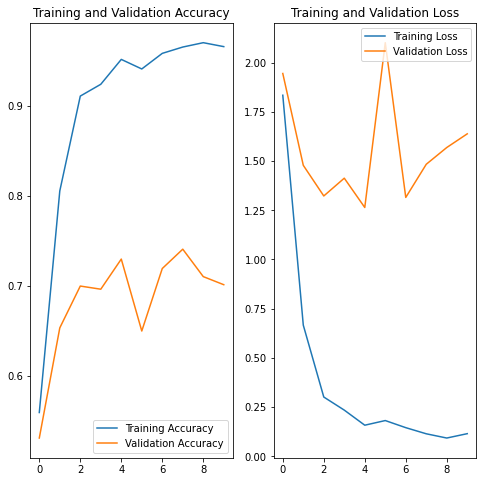

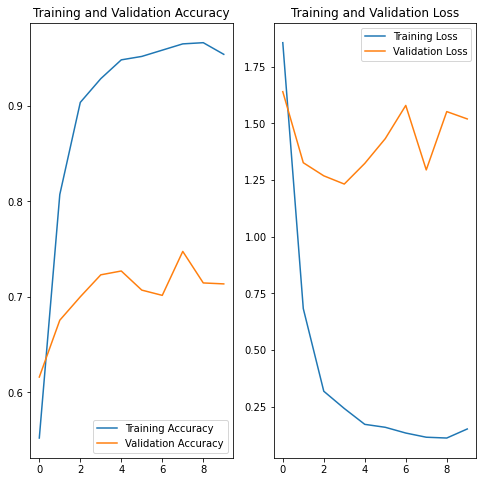

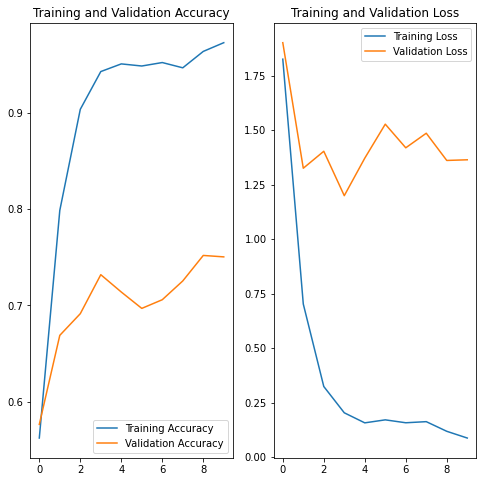

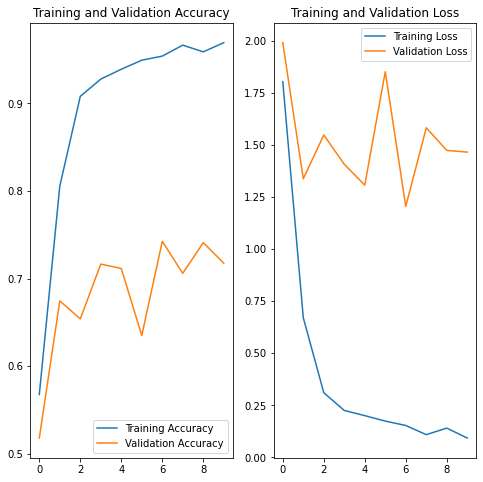

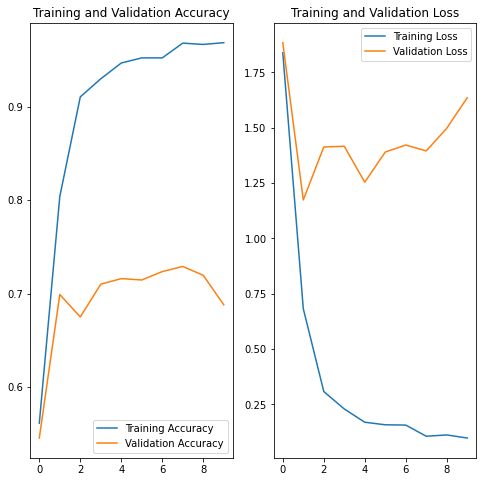

In [30]:
# hist
# for hist in histories:
plt.figure(1, figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()